In [1]:
import os
import shutil
import librosa
import numpy as np
import openl3
import soundfile as sf
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
def create_subset(data_dir, subset_dir, subset_ratio=0.1):
    """
    Create a subset of the data.

    Parameters:
    - data_dir: path to the original data directory.
    - subset_dir: path to the directory where the subset will be saved.
    - subset_ratio: fraction of data to be used in the subset is 10%.
    """

    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

    for species_folder in os.listdir(data_dir):
        original_folder_path = os.path.join(data_dir, species_folder)
        subset_folder_path = os.path.join(subset_dir, species_folder)

        if not os.path.exists(subset_folder_path):
            os.makedirs(subset_folder_path)

        files = [f for f in os.listdir(original_folder_path) if f.endswith(('.wav', '.mp3'))]
        num_files_in_subset = int(len(files) * subset_ratio)

        # Select a random subset of files
        selected_files = np.random.choice(files, num_files_in_subset, replace=False)

        # Copy selected files to the subset directory
        for file in selected_files:
            shutil.copy(os.path.join(original_folder_path, file), os.path.join(subset_folder_path, file))

    print(f"Subset created at: {subset_dir}")

data_dir = "D:\\Echo data2"
subset_dir = "D:\\Echo data2_subset"
create_subset(data_dir, subset_dir)


Subset created at: D:\Echo data2_subset


In [3]:
def load_audio_data(directory):
    audio_data = {}
    for folder in os.listdir(directory):
        audio_files = []
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.wav') or file.endswith('.mp3'):  # assuming audio files are in .wav or .mp3 format
                    file_path = os.path.join(folder_path, file)
                    y, sr = librosa.load(file_path, sr=None)  # y is the audio time series, sr is the sampling rate
                    audio_files.append((y, sr))
            audio_data[folder] = audio_files
    return audio_data


directory = 'D:\\Echo data2_subset'
data = load_audio_data(directory)


In [4]:
def preprocess_audio_data(data, target_sr=22050, target_duration=5.0):
    preprocessed_data = {}
    
    for species, audio_files in data.items():
        processed_files = []
        
        for y, sr in audio_files:
            # Resample to target sampling rate
            if sr != target_sr:
                y = librosa.resample(y=y, orig_sr=sr, target_sr=target_sr)
                sr = target_sr
            
            # Ensure audio has the same length
            target_length = int(target_sr * target_duration)
            if len(y) > target_length:
                y = y[:target_length]
            elif len(y) < target_length:
                padding = target_length - len(y)
                y = np.pad(y, (0, padding), 'constant')
            
            processed_files.append(y)
        
        preprocessed_data[species] = processed_files
    
    return preprocessed_data

# Preprocess the loaded data
preprocessed_data = preprocess_audio_data(data)


In [7]:
def is_silent(audio_data, threshold=1e-4):
    return np.mean(np.abs(audio_data)) < threshold

def extract_features(audio_data, sr=22050):
    # Check for silent audio
    if is_silent(audio_data):
        return None
    
    # Extracting MFCCs
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    
    # Extracting Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    
    # Extracting Chroma Feature
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    
    # Extracting Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    
    return {
        'mfccs': mfccs,
        'spectral_contrast': spectral_contrast,
        'chroma': chroma,
        'spectral_bandwidth': spectral_bandwidth
    }

# Example usage:
features = {}
for species, audio_files in preprocessed_data.items():
    species_features = [extract_features(y, sr=22050) for y in audio_files]
    species_features = [f for f in species_features if f is not None]  # Remove None values
    features[species] = species_features



D:\ANACONDA\lib\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [5]:
def augment_audio(audio_data, sr=22050):
    augmented_data = []
    
    # 1. Time-stretching
    rate = np.random.uniform(0.8, 1.2)  # Randomly choose a rate between 0.8 and 1.2
    stretched = librosa.effects.time_stretch(audio_data, rate=rate)
    augmented_data.append(stretched)
    
    # 2. Pitch shifting
    steps = np.random.randint(-5, 5)  # Randomly choose pitch shifting steps between -5 and 5
    shifted = librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=steps)
    augmented_data.append(shifted)
    
    # 3. Add noise
    noise = np.random.normal(0, 0.005, len(audio_data))  # Additive white noise
    noisy = audio_data + noise
    augmented_data.append(noisy)
    
    # 4. Time shifting
    shift = np.random.randint(-sr, sr)  # Randomly shift between -1s and 1s
    shifted = np.roll(audio_data, shift)
    if shift > 0:
        shifted[:shift] = 0
    else:
        shifted[shift:] = 0
    augmented_data.append(shifted)
    
    return augmented_data


In [29]:
def assign_labels_to_files(base_path):
    """
    Assign labels to audio files based on their directory names.
    """
    labels = []
    file_paths = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.wav', '.mp3')):  # or any other audio format you have
                file_path = os.path.join(root, file)
                label = os.path.basename(root)  # The directory name is our label
                file_paths.append(file_path)
                labels.append(label)

    return file_paths, labels

base_path = "D:\\Echo data2_subset"
file_paths, labels = assign_labels_to_files(base_path)


In [6]:
data_dir = "D:\\Echo data2_subset"

features = []
labels = []

for species_folder in os.listdir(data_dir):
    species_folder_path = os.path.join(data_dir, species_folder)
    
    if os.path.isdir(species_folder_path):
        for audio_file in os.listdir(species_folder_path):
            audio_file_path = os.path.join(species_folder_path, audio_file)
            
            y, sr = librosa.load(audio_file_path)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            
            features.append(mfccs)
            
            labels.append(species_folder)

print("Number of samples in features:", len(features))
print("Number of labels:", len(labels))


Number of samples in features: 170
Number of labels: 170


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into 80% for training and 20% for testing
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)

# Split the remaining 20% equally into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [2]:
pip install openl3

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): still running...
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
                                              0.0/323.4 kB ? eta -:--:--
     --------------------------             225.3/323.4 kB 6.7 MB/s eta 0:00:01
     -------------------------------------- 323.4/323.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/388.3 kB ? eta -:--:--
     --------------------                   204.8/388.3 kB 6.3 MB/s eta 0:00:01
     -------------------------

In [32]:
def extract_openl3_embeddings(audio_file_path):
    # Load audio file
    y, sr = sf.read(audio_file_path)
    
    # Get the embeddings using OpenL3
    embedding, ts = openl3.get_audio_embedding(y, sr, content_type="env", input_repr="mel256", embedding_size=512)
    
    avg_embedding = np.mean(embedding, axis=0)
    
    return avg_embedding

# Extract embeddings for all audio files
all_embeddings = []
for file_path in file_paths:
    embedding = extract_openl3_embeddings(file_path)
    all_embeddings.append(embedding)

all_embeddings = np.array(all_embeddings)


4/4 [==============================] - 11s 3s/step


D:\ANACONDA\lib\site-packages\openl3\core.py:82: OpenL3Warning: Duration of provided audio is shorter than window size (1 second). Audio will be padded.
  warnings.warn('Duration of provided audio is shorter than window size (1 second). Audio will be padded.',


25/25 [==============================] - 86s 3s/step


In [43]:
max_columns_train = max([x.shape[1] for x in X_train])
max_columns_val = max([x.shape[1] for x in X_val])
max_columns_test = max([x.shape[1] for x in X_test])
max_columns = max(max_columns_train, max_columns_val, max_columns_test)

X_train_padded = [np.pad(x, ((0,0), (0, max_columns - x.shape[1]))) for x in X_train]

X_val_padded = [np.pad(x, ((0,0), (0, max_columns - x.shape[1]))) for x in X_val]
X_test_padded = [np.pad(x, ((0,0), (0, max_columns - x.shape[1]))) for x in X_test]


In [60]:
# 1. Full Label Encoding Strategy
all_labels = y_train + y_val + y_test
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Encode the labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded, num_classes=16)
y_val_onehot = to_categorical(y_val_encoded, num_classes=16)
y_test_onehot = to_categorical(y_test_encoded, num_classes=16)




In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train_padded[0].shape)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='softmax')  # Change the number of neurons to 16
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_554 (Flatten)       (None, 583700)            0         
                                                                 
 dense_26 (Dense)            (None, 512)               298854912 
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 16)                4112      
                                                                 
Total params: 298990352 (1.11 GB)
Trainable params: 29

In [67]:
history = model.fit(np.array(X_train_padded), y_train_onehot, 
                    validation_data=(np.array(X_val_padded), y_val_onehot),
                    epochs=50, batch_size=32, verbose=1)


Epoch 1/50
3/3 [==============================] - 8s 2s/step - loss: 1713.7988 - accuracy: 0.1268 - val_loss: 8428.2549 - val_accuracy: 0.4444
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 9498.3174 - accuracy: 0.2817 - val_loss: 14567.1045 - val_accuracy: 0.2222
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 5907.8257 - accuracy: 0.3521 - val_loss: 15137.4219 - val_accuracy: 0.2222
Epoch 4/50
3/3 [==============================] - 7s 2s/step - loss: 6474.3130 - accuracy: 0.2958 - val_loss: 14677.1182 - val_accuracy: 0.3333
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 7808.2612 - accuracy: 0.3662 - val_loss: 12985.8594 - val_accuracy: 0.3333
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 7144.7764 - accuracy: 0.5070 - val_loss: 12945.4951 - val_accuracy: 0.3333
Epoch 7/50
3/3 [==============================] - 7s 2s/step - loss: 4244.7734 - accuracy: 0.4225 - val_loss: 15340.1045 - val_accuracy: 

1/1 [==============================] - 0s 111ms/step
Test Accuracy: 44.44%

Classification Report:
                                                precision    recall  f1-score   support

Aegotheles cristatus Australian owlet-nightjar       1.00      1.00      1.00         1
              Alauda arvensis European Skylark       0.00      0.00      0.00         1
    Caligavis chrysops Yellow-faced honeyeater       0.00      0.00      0.00         1
                       Capra hircus Feral goat       0.00      0.00      0.00         0
     Colluricincla harmonica Grey shrikethrush       0.00      0.00      0.00         0
                         Dama dama Fallow Deer       1.00      1.00      1.00         1
     Eopsaltria australis Eastern yellow robin       0.00      0.00      0.00         1
                               Felis Catus Cat       1.00      1.00      1.00         2
      Pachycephala rufiventris Rufous whistler       0.00      0.00      0.00         0
 Ptilotula penicilla

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall 

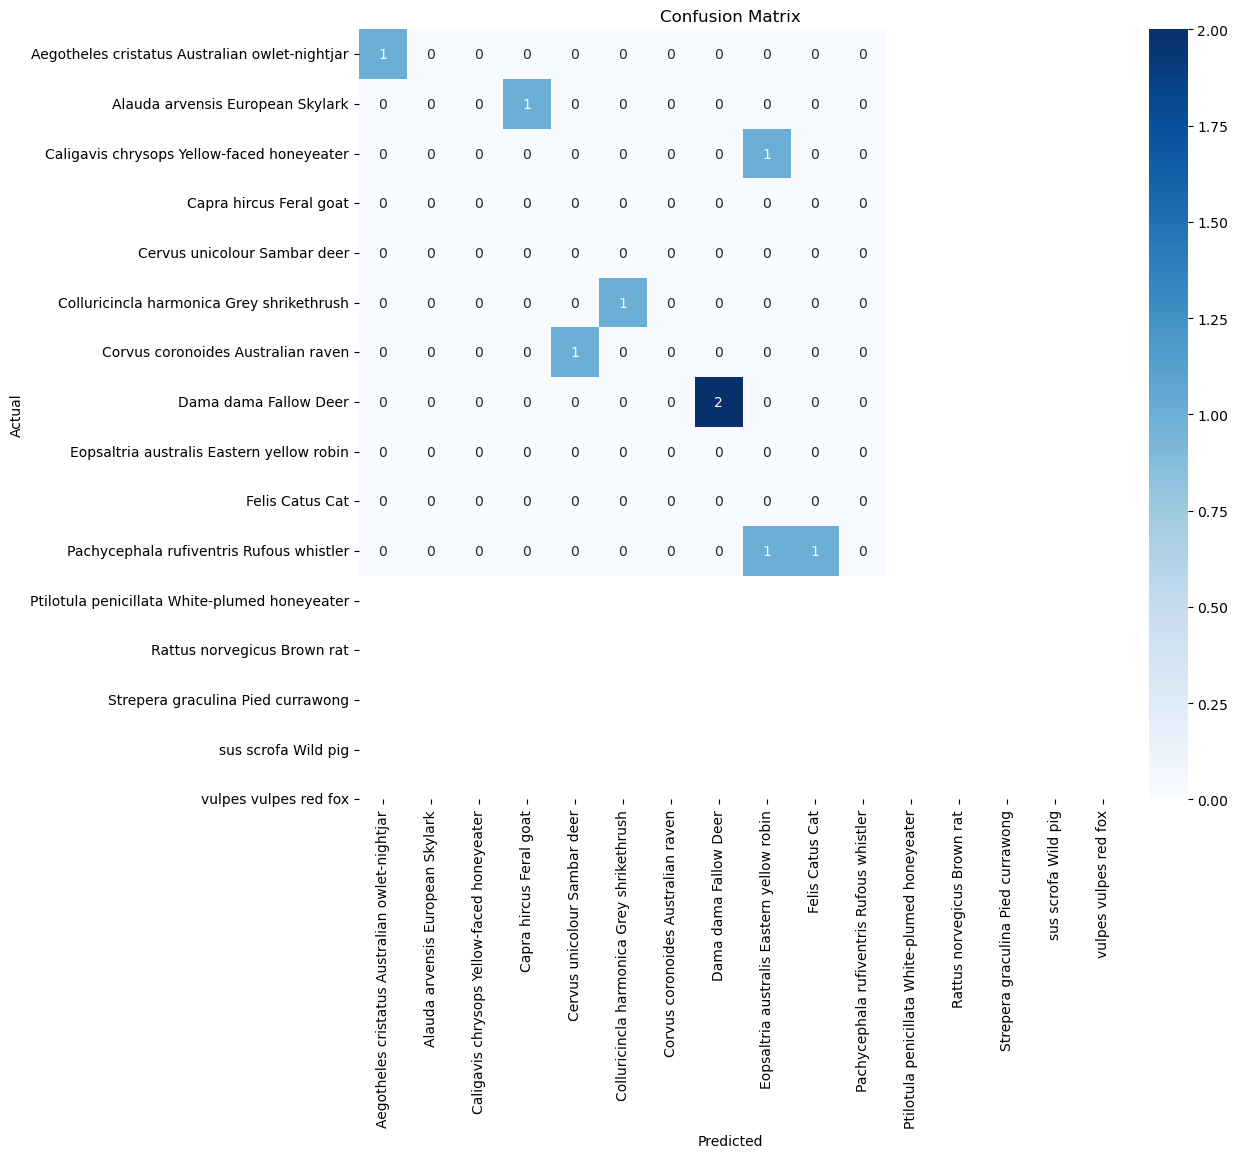

In [72]:
y_pred = model.predict(np.array(X_test_padded))
y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test_onehot, axis=1)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

unique_y_true = np.unique(y_true_labels)
unique_y_pred = np.unique(y_pred_labels)
all_unique_labels = np.unique(np.concatenate([unique_y_true, unique_y_pred]))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=all_unique_labels, target_names=label_encoder.inverse_transform(all_unique_labels)))


conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
